# Model training
This notebook consists of 4 parts:

1. Connecting to the Feature Store
2. Creating training data with the newest data in the "historic" feature views
3. Training models for each parking spot
4. Uploading/updating models and their performance in the Feature Store and Github

In [1]:
# Standard library imports
import os
import shutil
import joblib

# Data handling and analysis
import pandas as pd

# Visualization libraries
from matplotlib import pyplot
import seaborn as sns

# Machine Learning: model and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hopsworks-related imports
import hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


## 1. Connecting to the Feature Store

In [2]:
project = hopsworks.login(project="annikaij")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549019
Connected. Call `.close()` to terminate connection gracefully.


## 2. create training data

In [3]:
# Get the latest version of the magnetic field data feature view for bikelane
version=1
feature_view_mag_bikelane = fs.get_feature_view("hist_bikelane_mag_fv", version=version)

In [4]:
# Get the latest version of the training dataset
X_train, X_test, y_train, y_test = feature_view_mag_bikelane.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 
2024-05-26 11:24:04,673 WARNING: VersionWarning: Incremented version to `2`.



In [5]:
# Check the distribution of the target variable
y_train.value_counts(normalize=True)

mag_cluster 
no_detection    0.657999
detection       0.342001
Name: proportion, dtype: float64

## 3. Train, test and evaluate model for bikelane magnetic data

In [6]:
# Define the model
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred

array(['detection', 'no_detection', 'no_detection', ..., 'no_detection',
       'no_detection', 'no_detection'], dtype=object)

In [8]:
# make classification report
metrics = classification_report(y_test, y_pred, output_dict=True)
metrics

{'detection': {'precision': 0.9902152641878669,
  'recall': 0.9902152641878669,
  'f1-score': 0.9902152641878669,
  'support': 511.0},
 'no_detection': {'precision': 0.9950396825396826,
  'recall': 0.9950396825396826,
  'f1-score': 0.9950396825396826,
  'support': 1008.0},
 'accuracy': 0.9934167215273206,
 'macro avg': {'precision': 0.9926274733637748,
  'recall': 0.9926274733637748,
  'f1-score': 0.9926274733637748,
  'support': 1519.0},
 'weighted avg': {'precision': 0.9934167215273206,
  'recall': 0.9934167215273206,
  'f1-score': 0.9934167215273206,
  'support': 1519.0}}

In [9]:
# save the results in the model schema
results = confusion_matrix(y_test, y_pred)

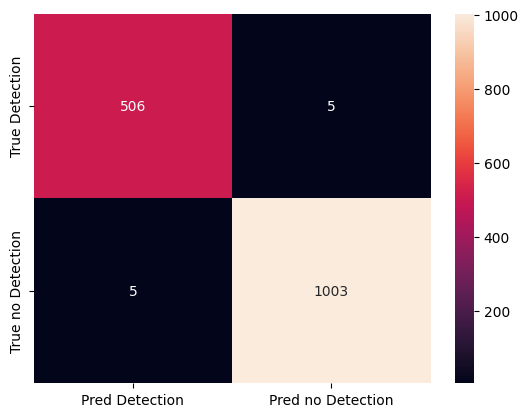

In [10]:
# Make and save the confusion matrix
df_cm = pd.DataFrame(results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

cm = sns.heatmap(df_cm, annot=True, fmt='g')

fig = cm.get_figure()
fig.savefig("/workspaces/2nd_semester_project/pictures/knn_mag_bikelane_matrix.png") 
fig.show()

## 2. Train, test and evaluate model for building magnetic data

In [11]:
# Getting the building mag feature view
version=1
feature_view_mag_building = fs.get_feature_view("hist_building_mag_fv", version=version)

In [12]:
# Get the latest version of the training dataset
t_X_train, t_X_test, t_y_train, t_y_test = feature_view_mag_building.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.60s) 
2024-05-26 11:24:09,617 WARNING: VersionWarning: Incremented version to `2`.



In [13]:
# Check the distribution of the target variable
t_y_train.value_counts(normalize=True)

mag_cluster 
no_detection    0.924005
detection       0.075995
Name: proportion, dtype: float64

In [14]:
# Define the model
t_model = KNeighborsClassifier(n_neighbors=2)
t_model.fit(t_X_train, t_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [15]:
# Make predictions on the test set
t_y_pred = t_model.predict(t_X_test)
t_y_pred

array(['no_detection', 'no_detection', 'no_detection', ...,
       'no_detection', 'no_detection', 'no_detection'], dtype=object)

In [16]:
# Make classification report
t_metrics = classification_report(t_y_test, t_y_pred, output_dict=True)
t_metrics

{'detection': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 122.0},
 'no_detection': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1411.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1533.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1533.0}}

In [17]:
# Save the results in the model schema
t_results = confusion_matrix(t_y_test, t_y_pred)
t_results

array([[ 122,    0],
       [   0, 1411]])

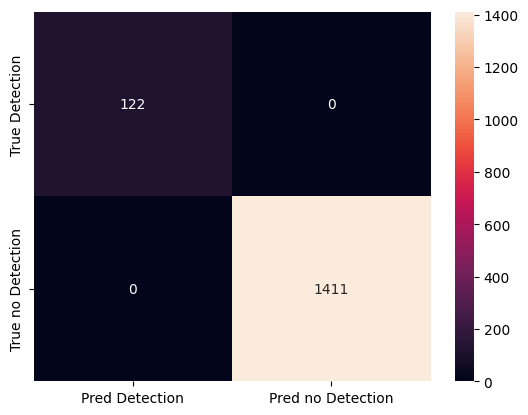

In [18]:
# Make and save the confusion matrix
t_df_cm = pd.DataFrame(t_results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

t_cm = sns.heatmap(t_df_cm, annot=True, fmt='g')

fig = t_cm.get_figure()
fig.savefig("/workspaces/2nd_semester_project/pictures/knn_mag_building_confusion_matrix.png") 
fig.show()

# Doing the same for radar data

In [19]:
# Get the latest version of the radar data feature view for bikelane
version=1
feature_view_rad_bikelane = fs.get_feature_view("hist_bikelane_radar_fv", version=version)
# Get the latest version of the training dataset
rad_bike_X_train, rad_bike_X_test, rad_bike_y_train, rad_bike_y_test = feature_view_rad_bikelane.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.62s) 
2024-05-26 11:24:18,192 WARNING: VersionWarning: Incremented version to `4`.



In [20]:
# Check the distribution of the target variable
rad_bike_y_train.value_counts(normalize=True)

radar_cluster
no_detection     0.843958
detection        0.156042
Name: proportion, dtype: float64

In [21]:
# Define the model
rad_bike_model = KNeighborsClassifier(n_neighbors=2)
rad_bike_model.fit(rad_bike_X_train, rad_bike_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [22]:
# Make predictions on the test set
rad_bike_y_pred = rad_bike_model.predict(rad_bike_X_test)
rad_bike_y_pred

array(['no_detection', 'no_detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection'

In [23]:
# Make classification report
rad_bike_metrics = classification_report(rad_bike_y_test, rad_bike_y_pred, output_dict=True)
rad_bike_metrics

{'detection': {'precision': 0.9795918367346939,
  'recall': 1.0,
  'f1-score': 0.9896907216494846,
  'support': 96.0},
 'no_detection': {'precision': 1.0,
  'recall': 0.9953488372093023,
  'f1-score': 0.9976689976689976,
  'support': 430.0},
 'accuracy': 0.9961977186311787,
 'macro avg': {'precision': 0.9897959183673469,
  'recall': 0.9976744186046511,
  'f1-score': 0.9936798596592411,
  'support': 526.0},
 'weighted avg': {'precision': 0.9962753162101342,
  'recall': 0.9961977186311787,
  'f1-score': 0.9962128864563108,
  'support': 526.0}}

In [24]:
# Save the results in the model schema
rad_bike_results = confusion_matrix(rad_bike_y_test, rad_bike_y_pred)
rad_bike_results

array([[ 96,   0],
       [  2, 428]])

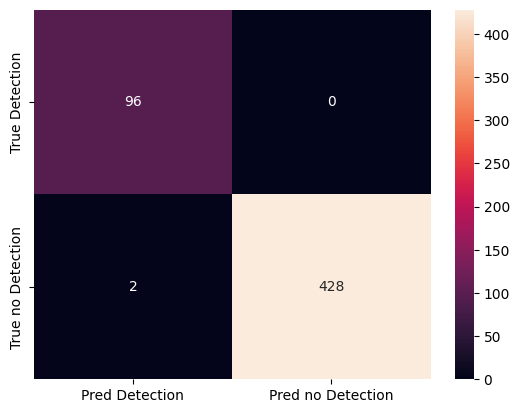

In [25]:
# Make and save the confusion matrix
rad_bike_df_cm = pd.DataFrame(rad_bike_results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

rad_bike_cm = sns.heatmap(rad_bike_df_cm, annot=True, fmt='g')

fig = rad_bike_cm.get_figure()
fig.savefig("/workspaces/2nd_semester_project/pictures/knn_rad_bike_confusion_matrix.png") 
fig.show()

### Building radar data

In [26]:
# Get the latest version of the radar data feature view for building
version=1
feature_view_rad_building = fs.get_feature_view("hist_building_radar_fv", version=version)
# Get the latest version of the training dataset
rad_building_X_train, rad_building_X_test, rad_building_y_train, rad_building_y_test = feature_view_rad_building.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
2024-05-26 11:28:13,582 WARNING: VersionWarning: Incremented version to `1`.



In [27]:
# Check the distribution of the target variable
rad_building_y_train.value_counts(normalize=True)

radar_cluster
no_detection     0.833799
detection        0.166201
Name: proportion, dtype: float64

In [28]:
# Define the model
rad_building_model = KNeighborsClassifier(n_neighbors=2)
rad_building_model.fit(rad_building_X_train, rad_building_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [29]:
# Make predictions on the test set
rad_building_y_pred = rad_building_model.predict(rad_building_X_test)
rad_building_y_pred

array(['detection', 'no_detection', 'detection', 'no_detection',
       'no_detection', 'detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'no_detection', 'no_detection', 'no_detection',
       'no_detection', 'detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no_detection', 'detection',
       'no_detection', 'no_detection', 'no

In [30]:
# Make classification report
rad_building_metrics = classification_report(rad_building_y_test, rad_building_y_pred, output_dict=True)
rad_building_metrics

{'detection': {'precision': 0.9876543209876543,
  'recall': 1.0,
  'f1-score': 0.9937888198757764,
  'support': 80.0},
 'no_detection': {'precision': 1.0,
  'recall': 0.9978118161925602,
  'f1-score': 0.9989047097480832,
  'support': 457.0},
 'accuracy': 0.9981378026070763,
 'macro avg': {'precision': 0.9938271604938271,
  'recall': 0.9989059080962801,
  'f1-score': 0.9963467648119297,
  'support': 537.0},
 'weighted avg': {'precision': 0.998160792698347,
  'recall': 0.9981378026070763,
  'f1-score': 0.9981425660054677,
  'support': 537.0}}

In [31]:
# Save the results in the model schema
rad_building_results = confusion_matrix(rad_building_y_test, rad_building_y_pred)
rad_building_results

array([[ 80,   0],
       [  1, 456]])

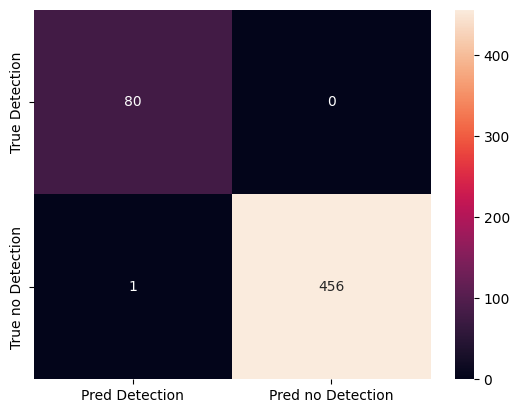

In [32]:
# Make and save the confusion matrix
rad_building_df_cm = pd.DataFrame(rad_building_results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

rad_building_cm = sns.heatmap(rad_building_df_cm, annot=True, fmt='g')

fig = rad_building_cm.get_figure()
fig.savefig("/workspaces/2nd_semester_project/pictures/knn_rad_building_confusion_matrix.png")
fig.show()

## 4. Uploading/updating models in the Feature Store

In [33]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [34]:
# uploading the building_mag_hist_model to the model registry
model_dir="models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/building_mag_hist_model.pkl")
shutil.copyfile("/workspaces/2nd_semester_project/pictures/knn_mag_building_confusion_matrix.png", model_dir + "/knn_mag_building_confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

building_mag_hist_model = mr.python.create_model(
    version=2,
    name="building_mag_hist_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Predictions on the parking spot close to the building with magnetic data",)

building_mag_hist_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19497 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/383142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18784 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/388710 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19100 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/613878 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/49 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/541 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549019/models/building_mag_hist_model/2


Model(name: 'building_mag_hist_model', version: 2)

In [35]:
# uploading the bikelane_mag_hist_model to the model registry
model_dir="models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(t_model, model_dir + "/bikelane_mag_hist_model.pkl")
shutil.copyfile("/workspaces/2nd_semester_project/pictures/knn_mag_bikelane_matrix.png", model_dir + "/knn_mag_bikelane_matrix.png")

input_example = t_X_train.sample()
input_schema = Schema(t_X_train)
output_schema = Schema(t_y_train)
model_schema = ModelSchema(input_schema, output_schema)

bikelane_mag_hist_model = mr.python.create_model(
    version=2,
    name="bikelane_mag_hist_model", 
    metrics={"accuracy" : t_metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Predictions on the parking spot close to the bikelane with magnetic data",)

bikelane_mag_hist_model.save(model_dir)



  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17994 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19497 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/383142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18784 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/619254 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/388710 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19100 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/613878 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/51 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/541 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549019/models/bikelane_mag_hist_model/2


Model(name: 'bikelane_mag_hist_model', version: 2)

In [36]:
# uploading the building_rad_hist_model to the model registry
model_dir="models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(rad_building_model, model_dir + "/building_rad_hist_model.pkl")
shutil.copyfile("/workspaces/2nd_semester_project/pictures/knn_rad_building_confusion_matrix.png", model_dir + "/knn_rad_building_confusion_matrix.png")

input_example = rad_building_X_train.sample()
input_schema = Schema(rad_building_X_train)
output_schema = Schema(rad_building_y_train)
model_schema = ModelSchema(input_schema, output_schema)

building_rad_hist_model = mr.python.create_model(
    version=2,
    name="building_rad_hist_model", 
    metrics={"accuracy" : rad_building_metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Predictions on the parking spot close to the building with radar data",)

building_rad_hist_model.save(model_dir)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17994 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19497 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/383142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/404550 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18784 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/619254 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/388710 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19100 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/613878 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/16872 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/50 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/911 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549019/models/building_rad_hist_model/2


Model(name: 'building_rad_hist_model', version: 2)

In [37]:
# uploading the bikelane_rad_hist_model to the model registry
model_dir="models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(rad_bike_model, model_dir + "/bikelane_rad_hist_model.pkl")
shutil.copyfile("/workspaces/2nd_semester_project/pictures/knn_rad_bike_confusion_matrix.png", model_dir + "/knn_rad_bike_confusion_matrix.png")

input_example = rad_bike_X_train.sample()
input_schema = Schema(rad_bike_X_train)
output_schema = Schema(rad_bike_y_train)
model_schema = ModelSchema(input_schema, output_schema)

bikelane_rad_hist_model = mr.python.create_model(
    version=2,
    name="bikelane_rad_hist_model", 
    metrics={"accuracy" : rad_bike_metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Predictions on the parking spot close to the bikelane with radar data",)

bikelane_rad_hist_model.save(model_dir)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19736 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17994 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19497 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/383142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/404550 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18784 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/396454 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/619254 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/388710 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19100 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/613878 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/16872 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/76 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/911 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549019/models/bikelane_rad_hist_model/2


Model(name: 'bikelane_rad_hist_model', version: 2)

## **Next up:** 5: Inference pipeline
Go to the 5_inference_pipeline.ipynb notebook